In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


## Used Bayesian inference to infer the parameters of a (linearised) gLV model

The generalized Lotka-Volterra equation takes the form

$$ \frac{dX_i}{dt} = \mu_i X_i + X_i M_{ij} X_j + X_i \epsilon_{il} u_l $$

where:
-   $X_i$ is the concentration of a species
-   $\mu_i$ is its specific growth rate
-   $M_{ij}$ is the effect of the interaction of species $i$ on species $j$
-   $\epsilon_{il}$ is the susceptibility to the time-dependent perturbation $u_l$

### Bayesian inference with no shrinkage    

X shape: (99, 6)
F shape: (99, 5)
Number of species: 5
AdvancedSetSubtensor.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site

                 mean     sd  r_hat
mu_hat[0, 0]    1.137  0.459   1.01
mu_hat[0, 1]    0.954  0.451   1.01
mu_hat[0, 2]    1.343  0.458   1.00
mu_hat[0, 3]    0.986  0.452   1.00
mu_hat[0, 4]    1.199  0.082   1.00
M_ii_hat[0]    -0.081  0.061   1.00
M_ii_hat[1]    -0.080  0.063   1.00
M_ii_hat[2]    -0.082  0.059   1.00
M_ii_hat[3]    -0.081  0.059   1.00
M_ii_hat[4]    -0.225  0.015   1.00
M_ij_hat[0, 0] -0.111  0.054   1.00
M_ij_hat[0, 1] -0.029  0.055   1.00
M_ij_hat[0, 2]  0.096  0.054   1.00
M_ij_hat[0, 3]  0.013  0.054   1.00
M_ij_hat[1, 0] -0.023  0.035   1.00
M_ij_hat[1, 1] -0.108  0.036   1.01
M_ij_hat[1, 2]  0.043  0.036   1.00
M_ij_hat[1, 3]  0.017  0.035   1.00
M_ij_hat[2, 0]  0.048  0.052   1.00
M_ij_hat[2, 1]  0.009  0.053   1.00
M_ij_hat[2, 2] -0.203  0.051   1.00
M_ij_hat[2, 3] -0.012  0.053   1.00
M_ij_hat[3, 0]  0.016  0.022   1.00
M_ij_hat[3, 1]  0.056  0.023   1.01
M_ij_hat[3, 2] -0.029  0.023   1.00
M_ij_hat[3, 3] -0.020  0.022   1.00
M_ij_hat[4, 0]  0.003  0.037

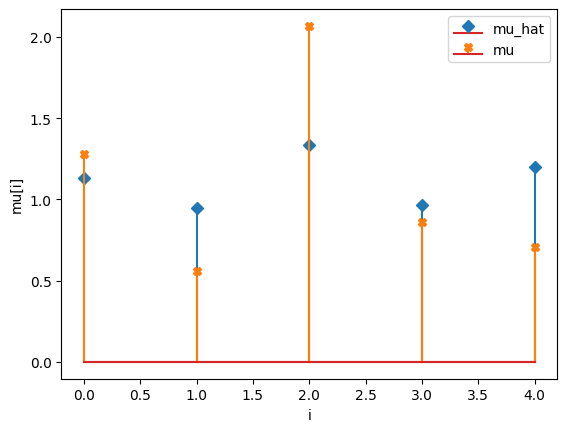

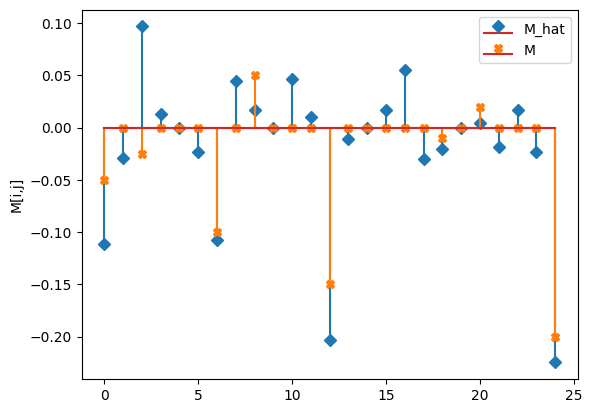

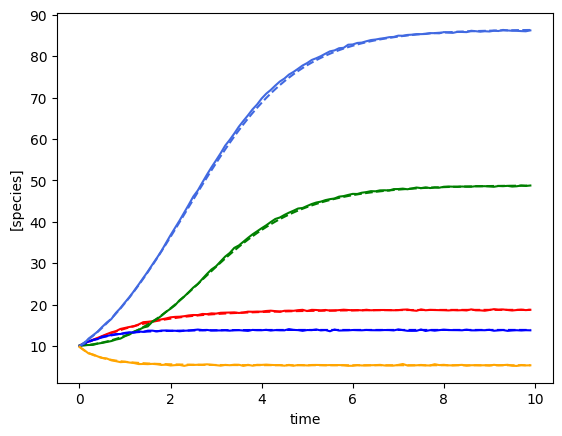

In [ ]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 1
data = pd.read_csv("data-s5-r1.csv")
times = data.iloc[:, 0].values

yobs = data.iloc[:, 1:6].values

X, F = linearize_time_course_16S(yobs, times)

# Define priors
prior_mu_mean = 1.0 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
#inference.plot_posterior(idata)


summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)


In [3]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 3
data = pd.read_csv("data-s5-r3.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])


X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)



for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])
 
init_species = ryobs[timecourse_idx,0,:]  


X shape: (297, 6)
F shape: (297, 5)
Number of species: 5
AdvancedSetSubtensor.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 37 seconds.
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encoun

mu_hat/mu:
[1.3832308  0.74120724 1.77738998 0.95705513 0.80500161]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.06 -0.    0.   -0.    0.  ]
 [ 0.   -0.09  0.    0.    0.  ]
 [-0.03 -0.01 -0.13 -0.01  0.  ]
 [-0.    0.04  0.   -0.01  0.  ]
 [ 0.    0.01  0.    0.   -0.15]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]


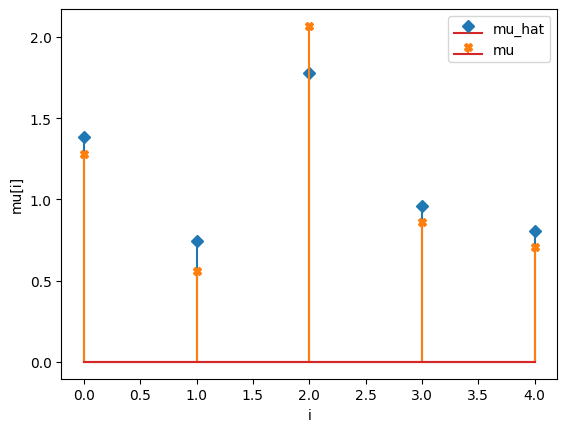

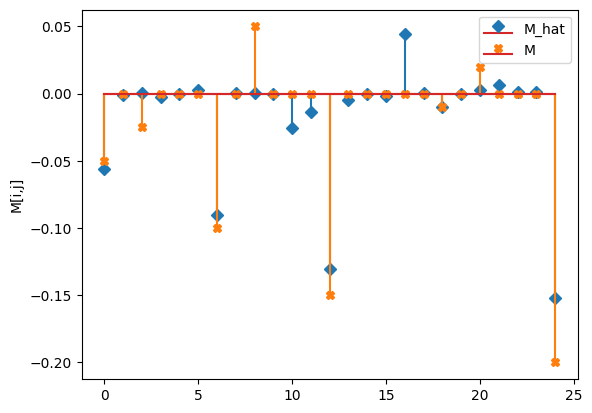

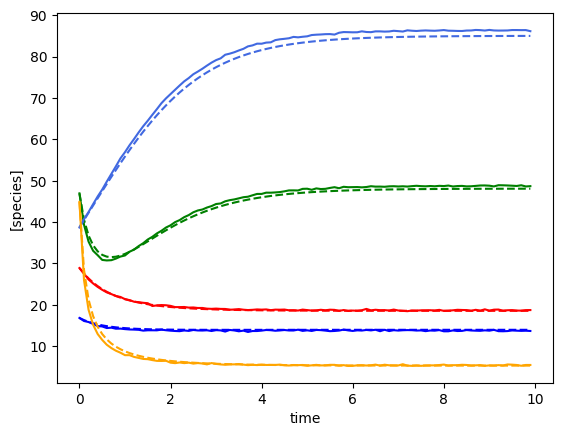

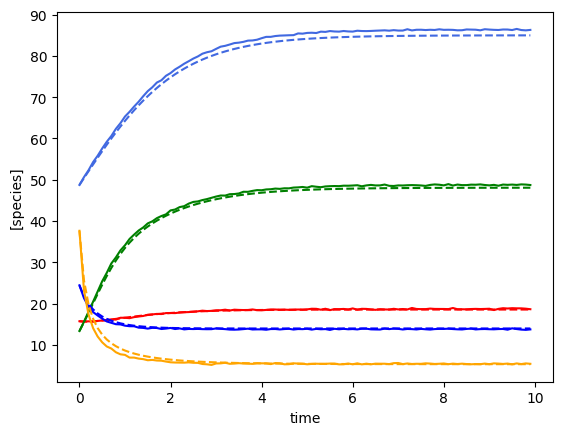

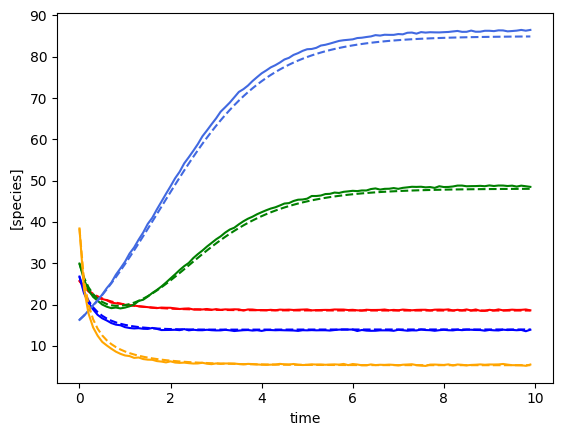

In [ ]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 3
data = pd.read_csv("data-s5-r3.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])

X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)

for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])


# Define priors
prior_mu_mean = [1.0] 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
#inference.plot_posterior(idata)


summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
#print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

compare_params(mu=(mu, mu_h), M=(M, M_h))

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)

# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=ryobs[timecourse_idx,0,:])
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h, times)



### Bayesian inference with shrinkage: Horseshoe prior

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + nu

                 mean     sd  r_hat
mu_hat[0, 0]    1.045  0.204   1.00
mu_hat[0, 1]    0.573  0.114   1.01
mu_hat[0, 2]    1.754  0.133   1.00
mu_hat[0, 3]    0.849  0.096   1.01
mu_hat[0, 4]    0.804  0.012   1.00
M_ii_hat[0]    -0.079  0.061   1.01
M_ii_hat[1]    -0.078  0.059   1.00
M_ii_hat[2]    -0.079  0.059   1.00
M_ii_hat[3]    -0.080  0.059   1.00
M_ii_hat[4]    -0.152  0.002   1.00
M_ij_hat[0, 0] -0.048  0.006   1.01
M_ij_hat[0, 1]  0.000  0.004   1.00
M_ij_hat[0, 2]  0.000  0.003   1.01
M_ij_hat[0, 3]  0.000  0.003   1.01
M_ij_hat[1, 0]  0.000  0.002   1.01
M_ij_hat[1, 1] -0.089  0.003   1.01
M_ij_hat[1, 2]  0.000  0.001   1.00
M_ij_hat[1, 3] -0.000  0.002   1.01
M_ij_hat[2, 0] -0.012  0.009   1.01
M_ij_hat[2, 1] -0.001  0.005   1.01
M_ij_hat[2, 2] -0.129  0.007   1.00
M_ij_hat[2, 3] -0.001  0.004   1.01
M_ij_hat[3, 0]  0.000  0.001   1.01
M_ij_hat[3, 1]  0.044  0.002   1.01
M_ij_hat[3, 2]  0.000  0.001   1.00
M_ij_hat[3, 3] -0.010  0.001   1.01
M_ij_hat[4, 0] -0.001  0.002

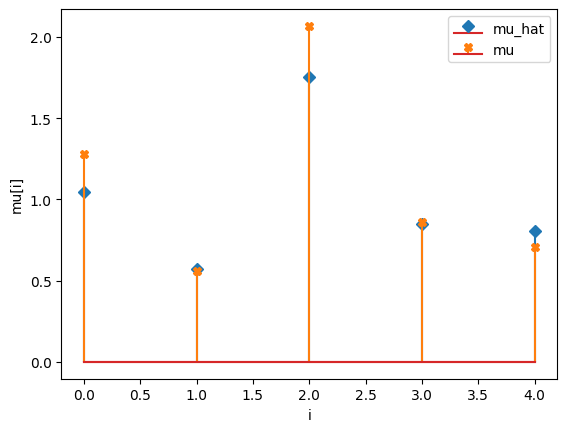

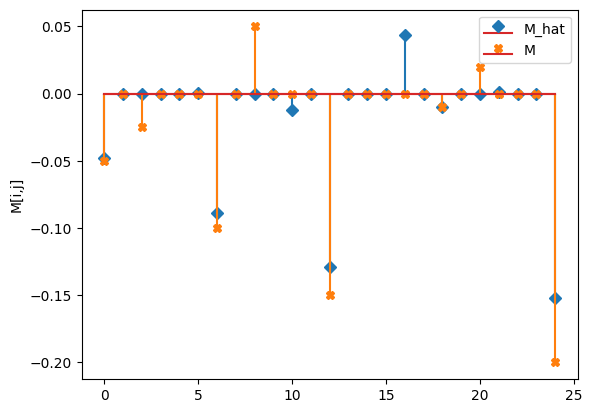

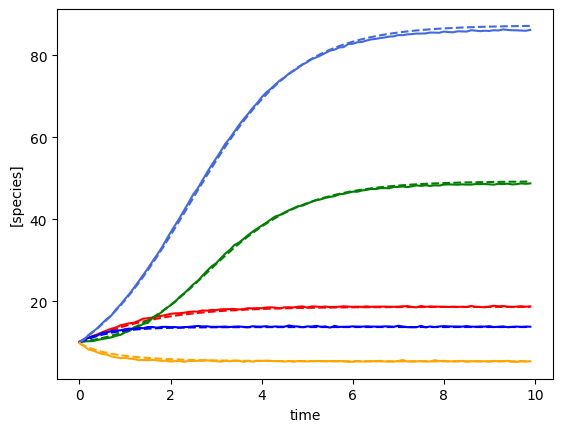

In [ ]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 1
data = pd.read_csv("data-s5-r1.csv")
times = data.iloc[:, 0].values


# Define priors
prior_mu_mean = [1.0] 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference_shrinkage()

# To plot posterior distributions
#inference.plot_posterior(idata)




#nX = num_species
#n_obs = times.shape[0] - 1
#noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
#DA = nX*nX - nX
#DA0 = 3     # expected number of non zero entries in M_ij
#N = n_obs - 2

#inference = infergLVbayes(X, F, mu_prior, M_prior, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev)
#idata = inference.run_bayes_gLV_shrinkage()

# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)

### Bayesian inference with shrinkage and a perturbation with unknown interactions
Now we will do inference with the Horseshoe prior for shrinkage but now we include a perturbation (assuming unknown interaction terms). This gives more identifiability

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, epsilon_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 33 seconds.


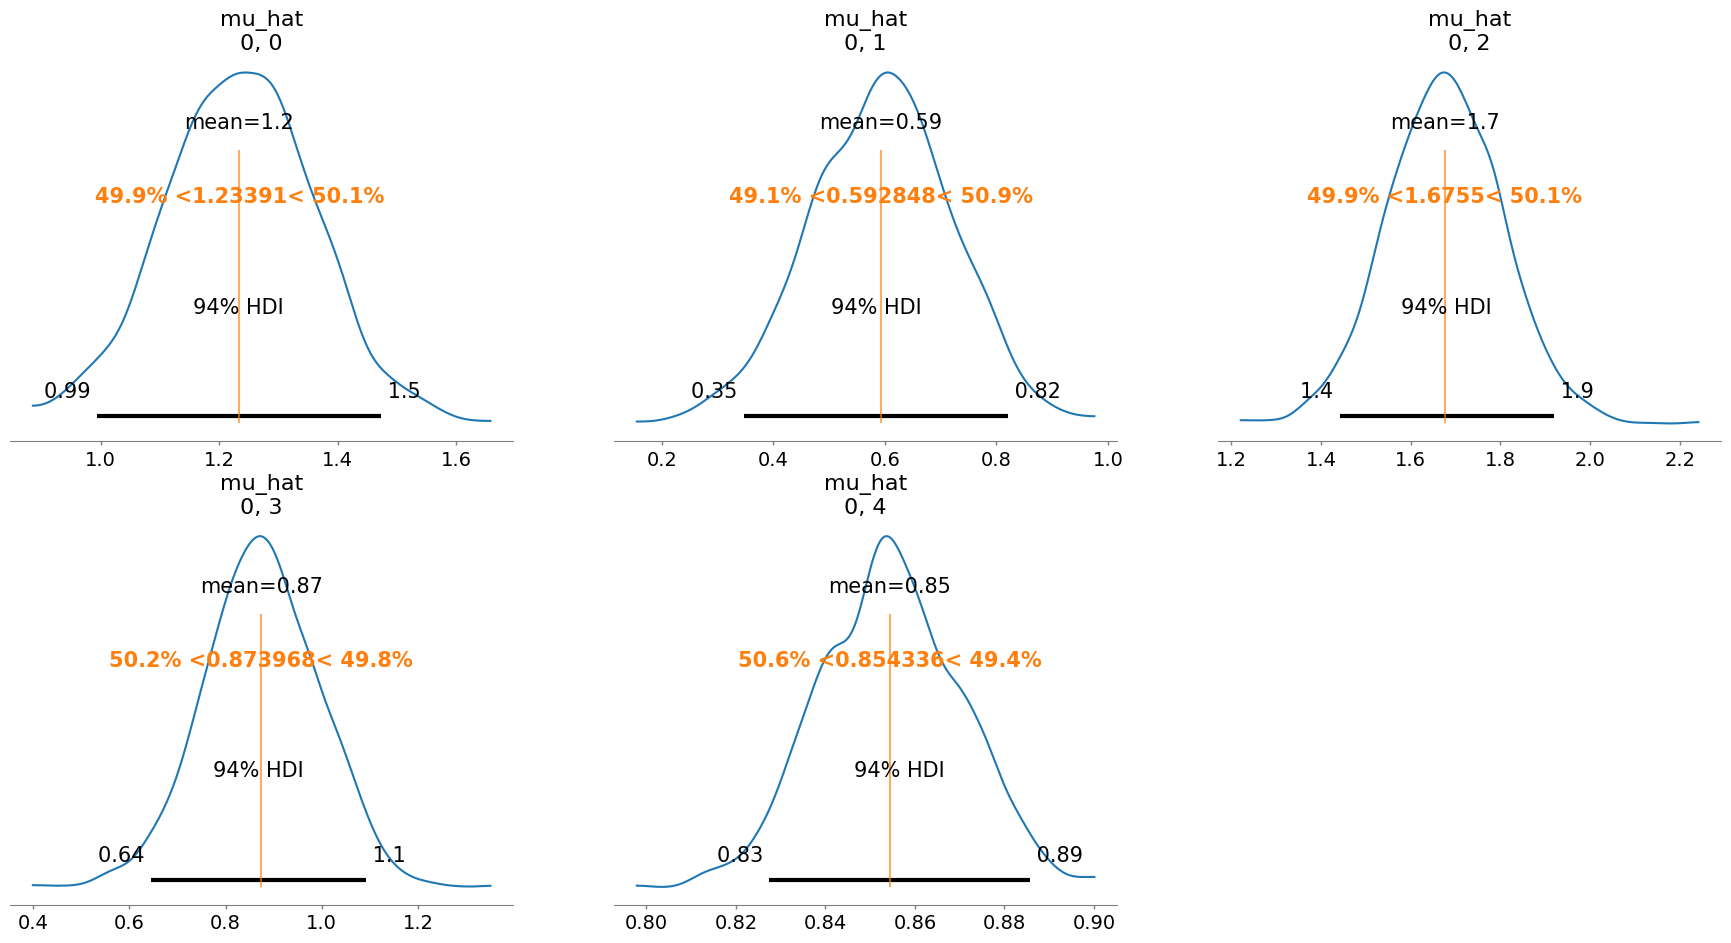

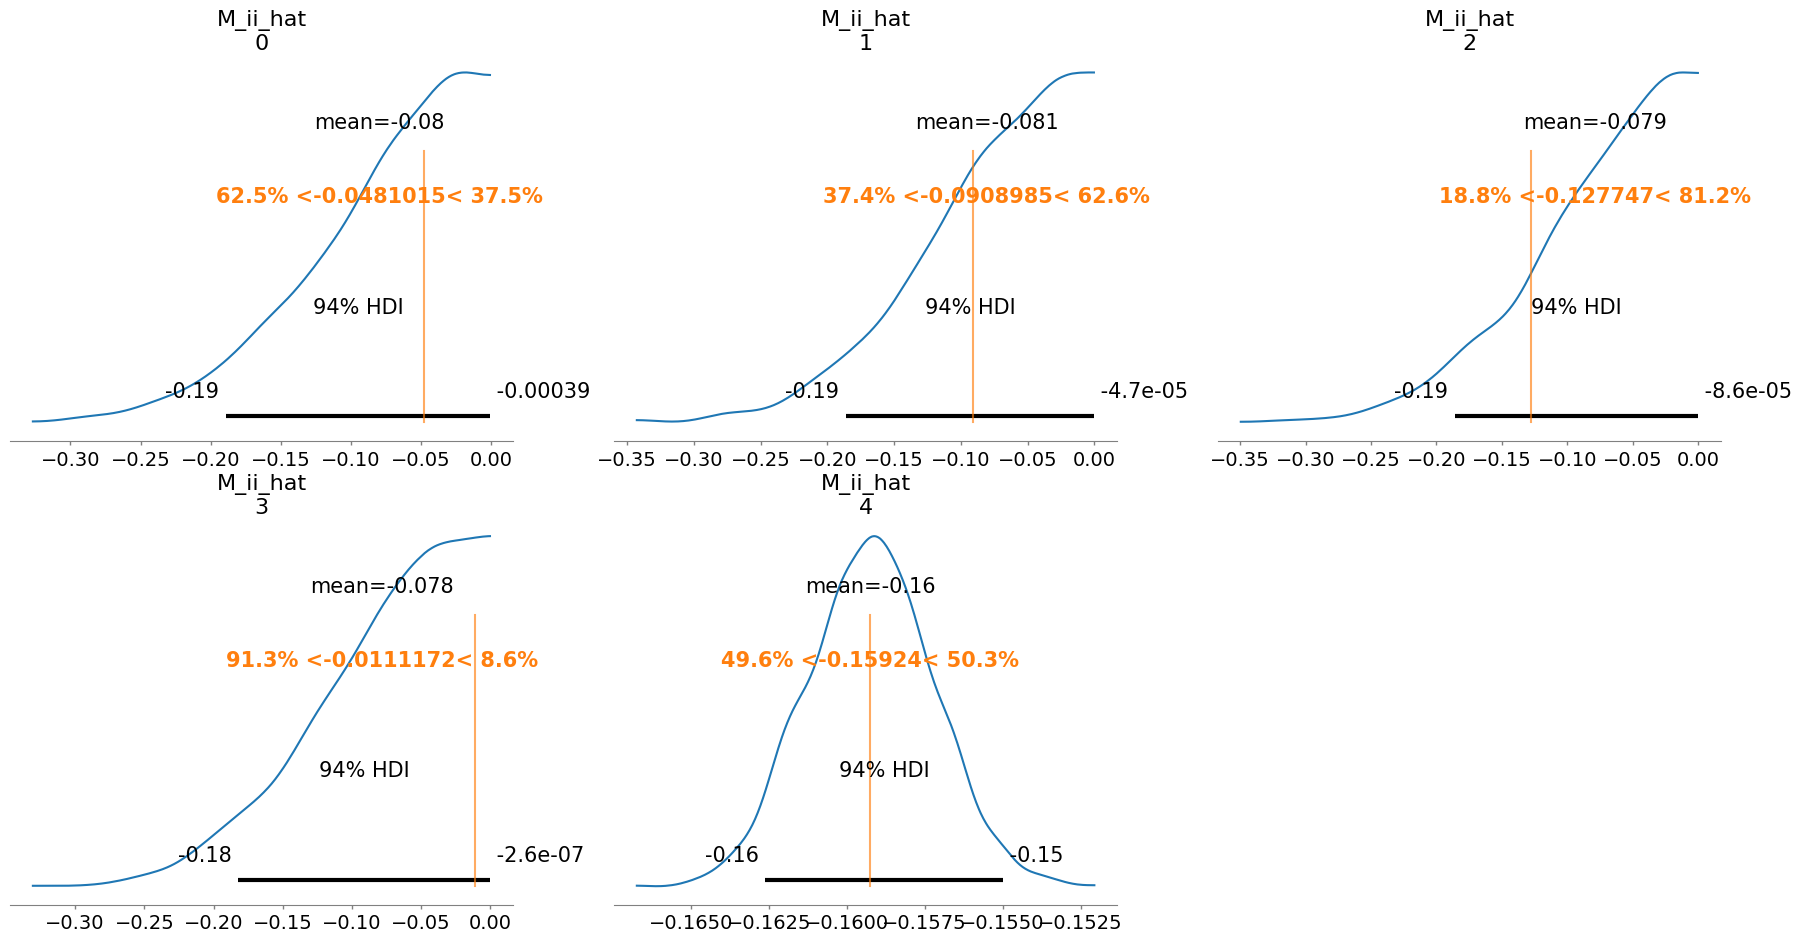

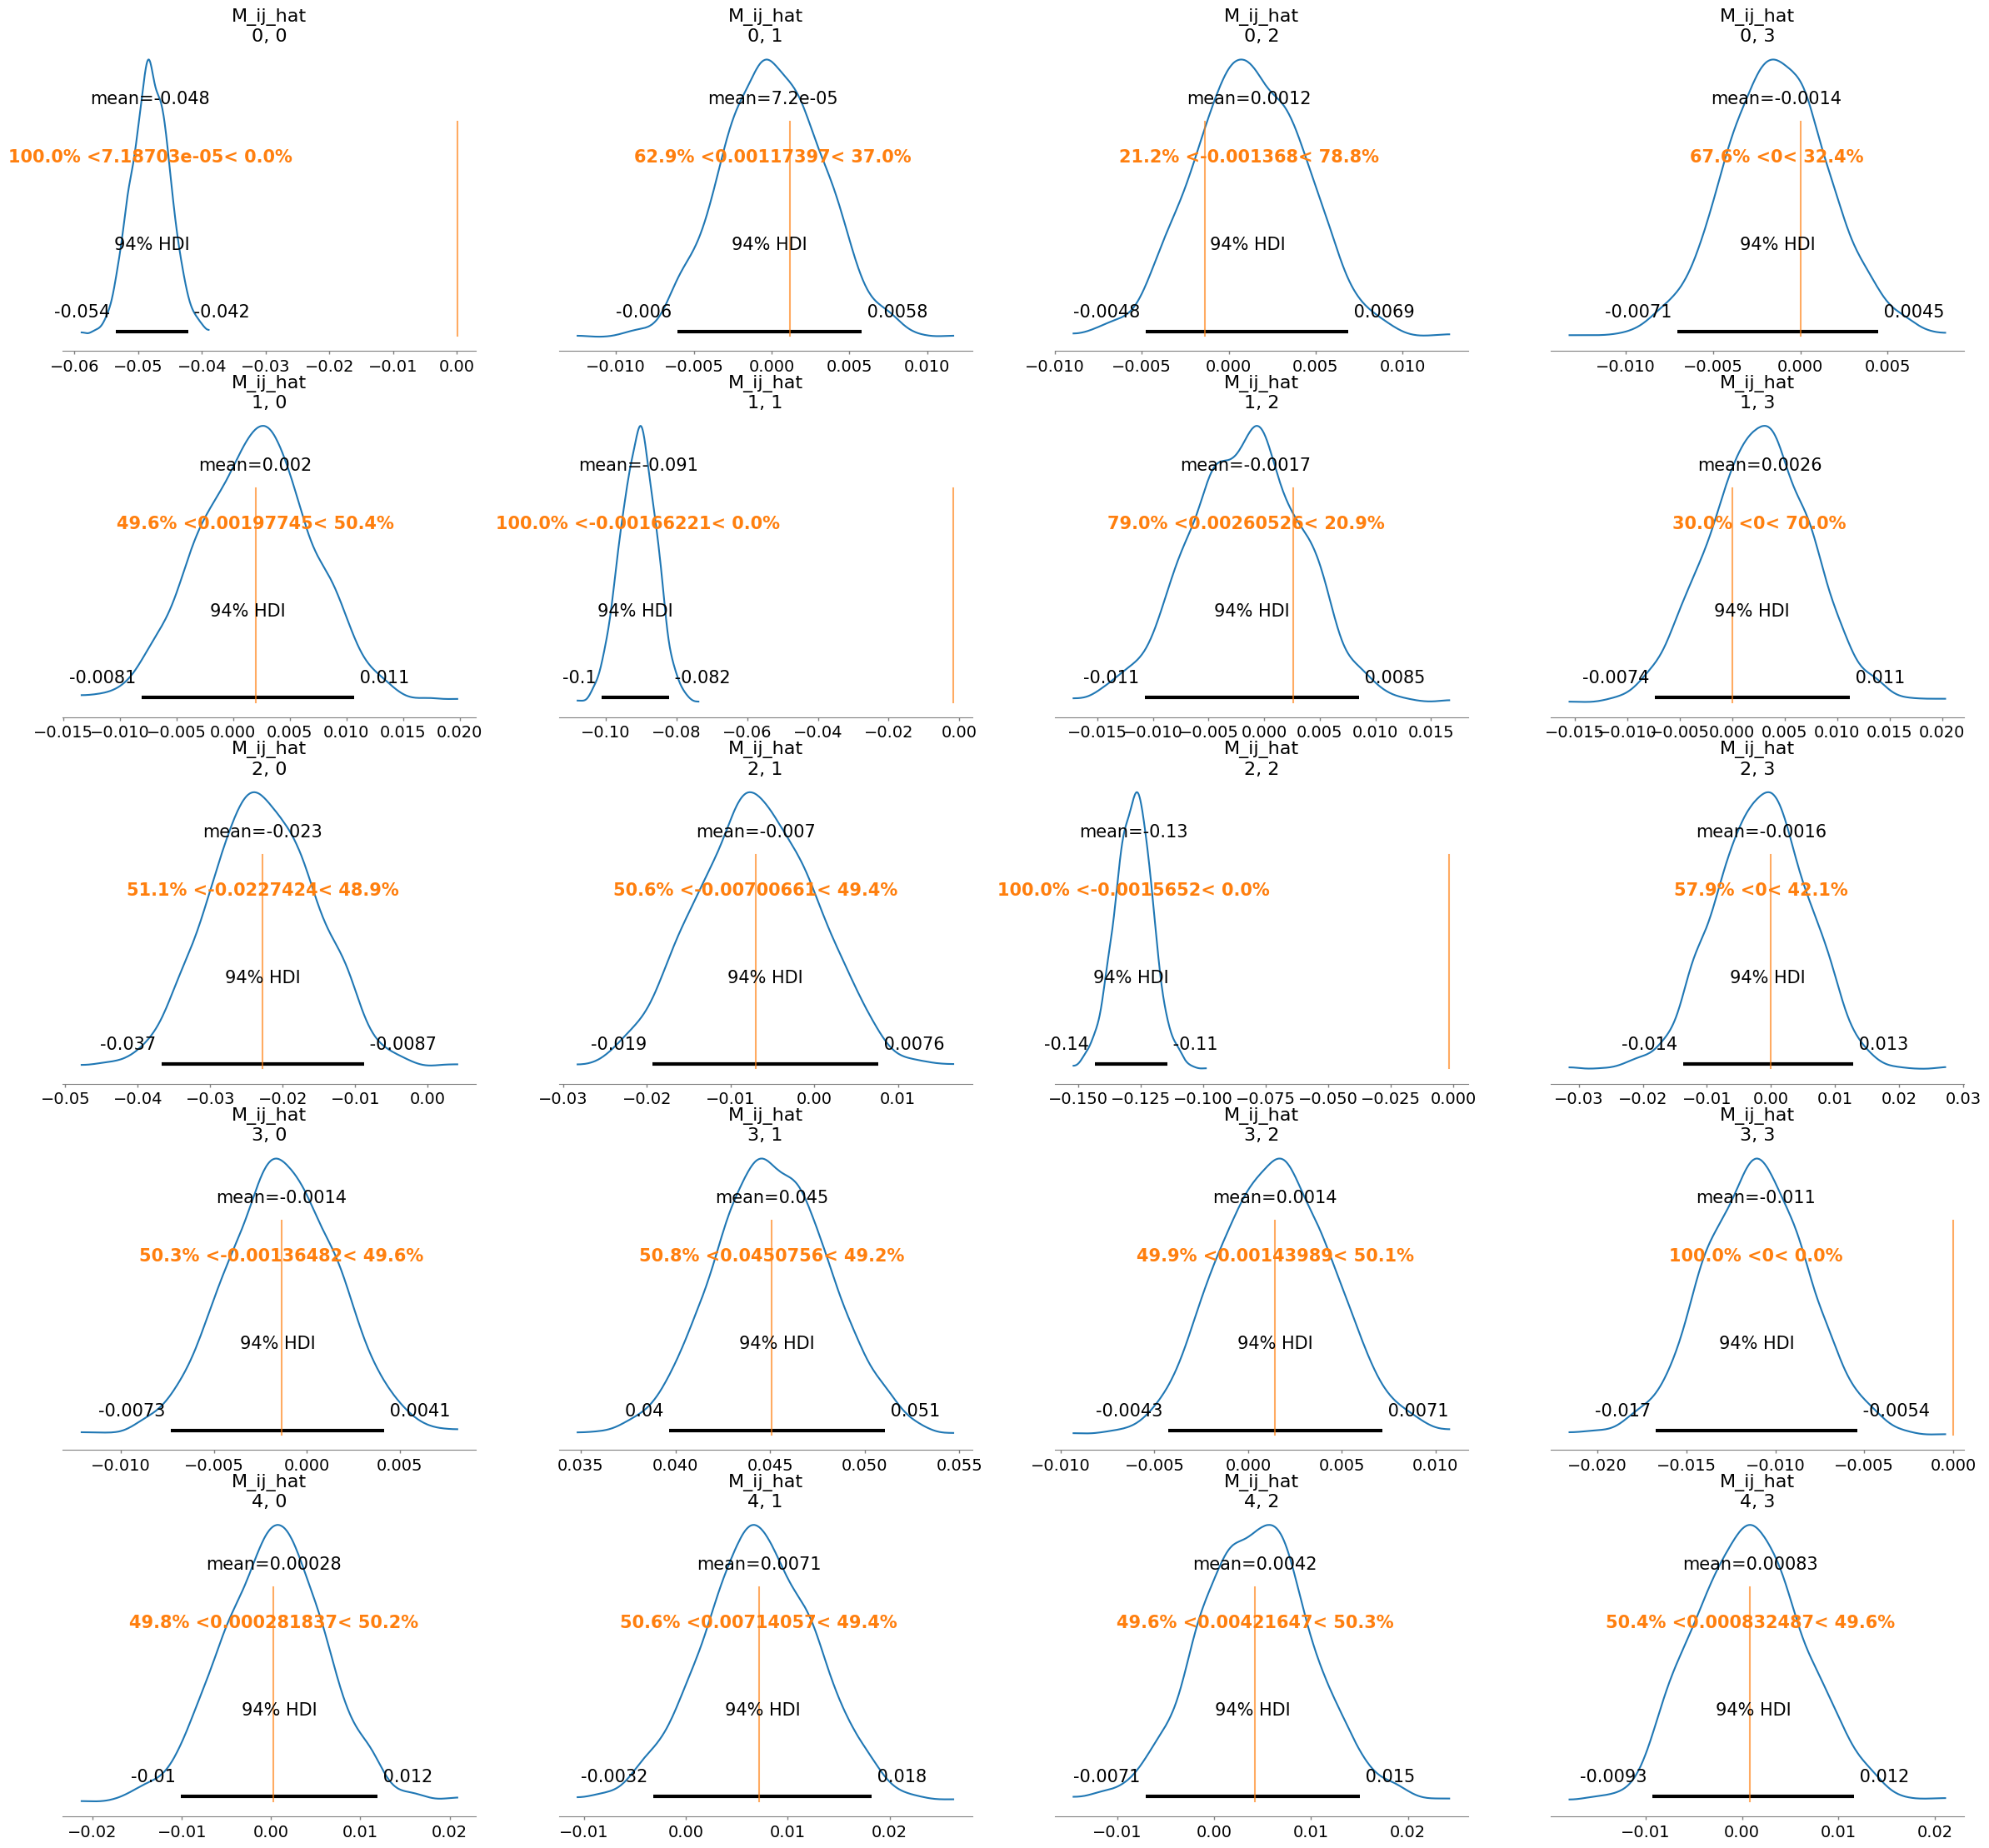

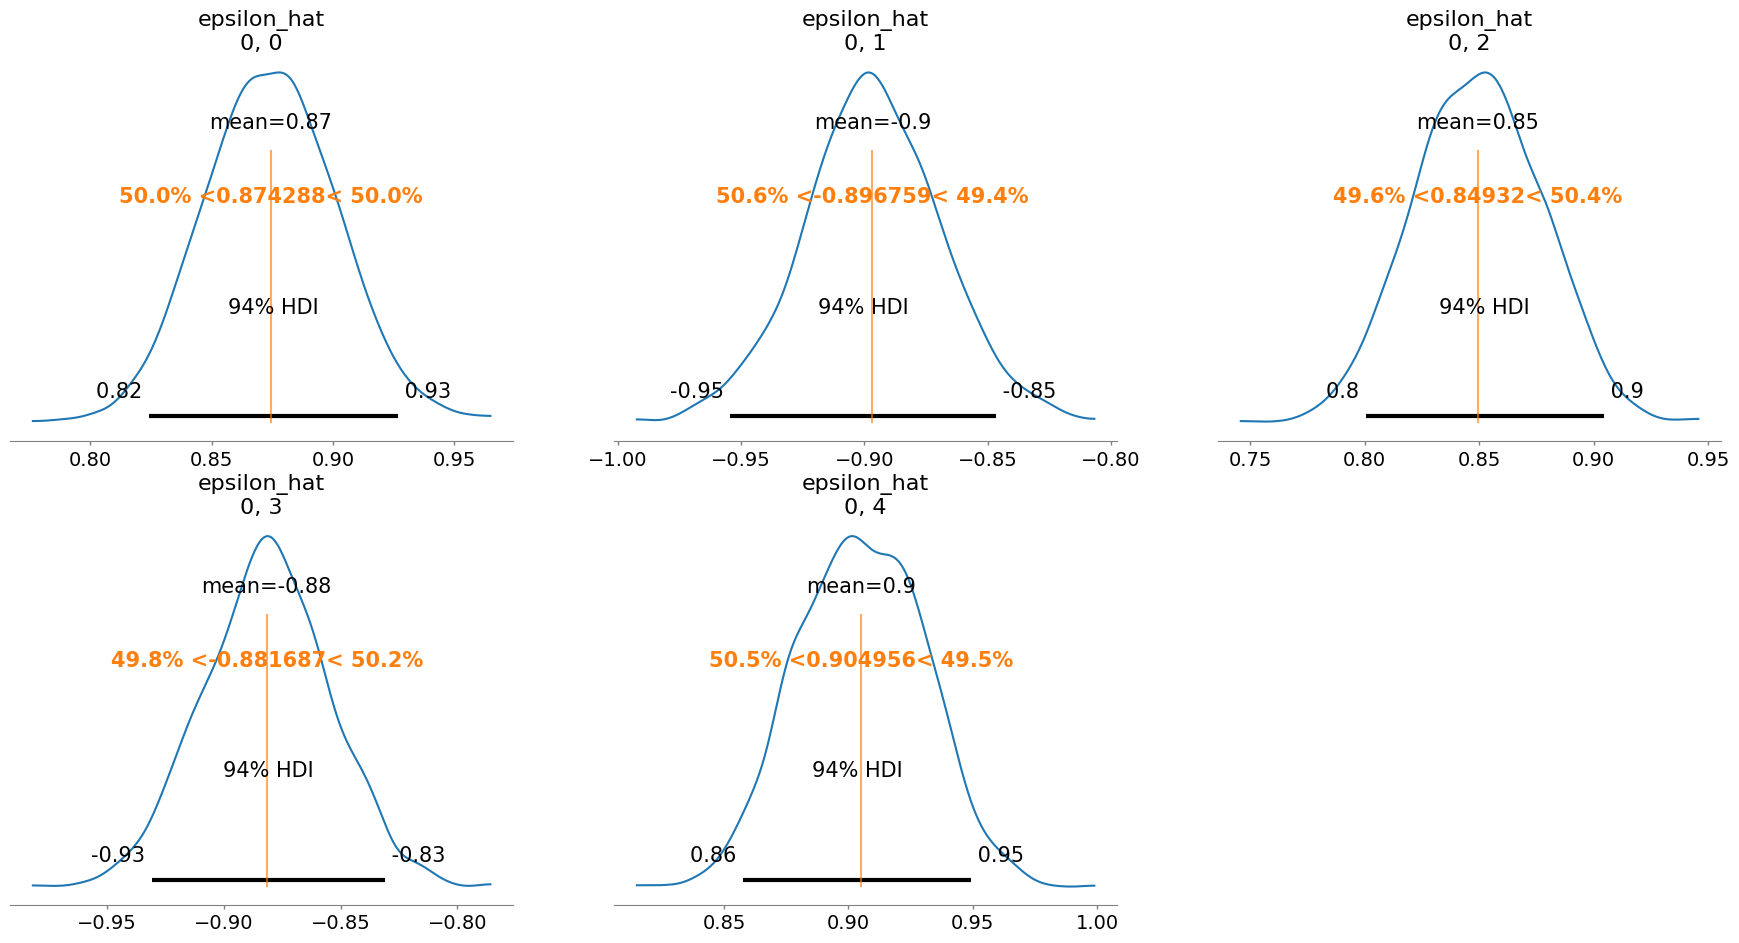

/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_s

                    mean     sd  r_hat
mu_hat[0, 0]       1.234  0.126   1.00
mu_hat[0, 1]       0.593  0.127   1.00
mu_hat[0, 2]       1.676  0.128   1.00
mu_hat[0, 3]       0.874  0.121   1.00
mu_hat[0, 4]       0.854  0.016   1.00
...                  ...    ...    ...
epsilon_hat[0, 1] -0.897  0.028   1.00
epsilon_hat[0, 2]  0.849  0.028   1.01
epsilon_hat[0, 3] -0.882  0.027   1.00
epsilon_hat[0, 4]  0.905  0.025   1.00
sigma[0]           0.116  0.002   1.00

[61 rows x 3 columns]
(5, 1)
mu_hat/mu:
[1.2340641  0.59576028 1.67578969 0.87263399 0.85407882]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.05  0.    0.   -0.    0.  ]
 [ 0.   -0.09 -0.    0.    0.  ]
 [-0.02 -0.01 -0.13 -0.    0.  ]
 [-0.    0.04  0.   -0.01  0.  ]
 [ 0.    0.01  0.    0.   -0.16]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]

e_hat/e

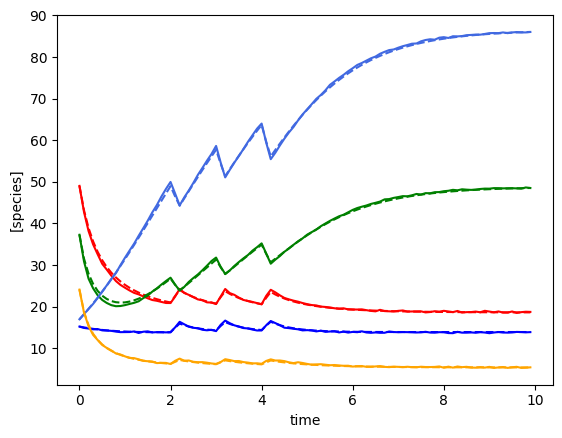

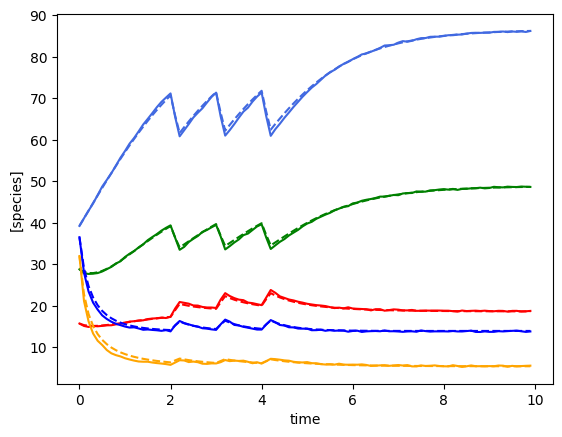

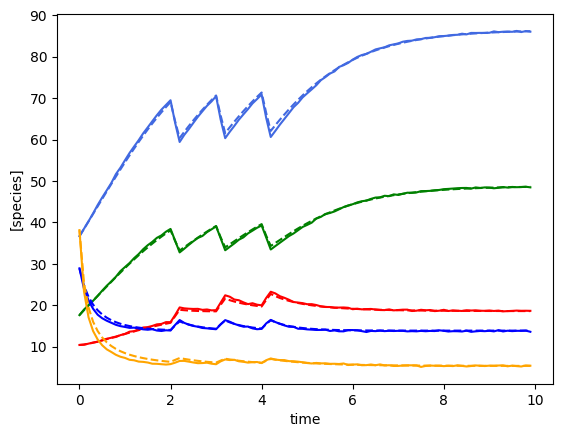

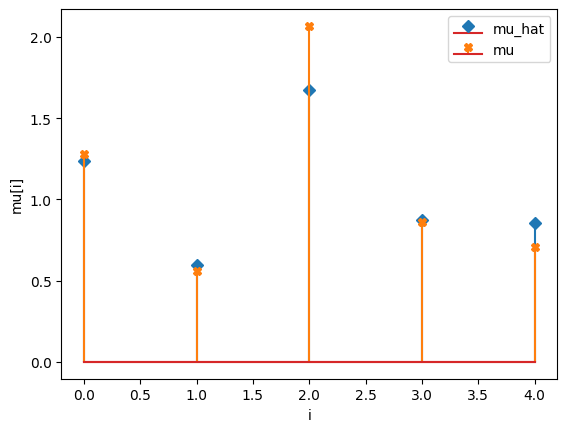

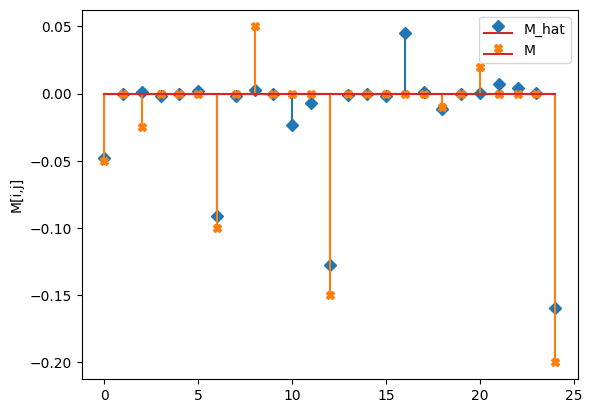

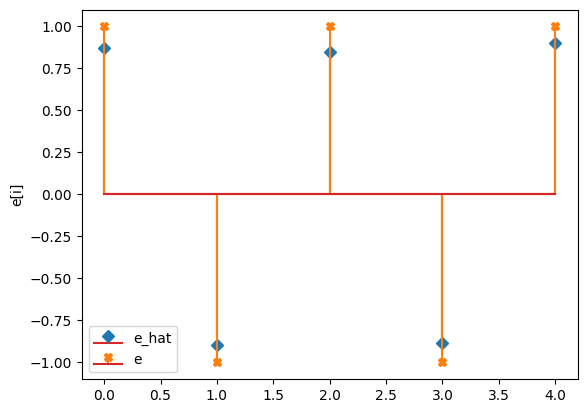

In [7]:
num_timecourses = 3
num_perturbations = 1
data = pd.read_csv("data-s5-r3-p1.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])

# create the perturbation signal
def pert_fn(t):
    if 2.0 <= t < 2.2 or 3.0 <= t < 3.2 or 4.0 <= t < 4.2:
        return np.array([1])
    else: 
        return np.array([0])

u = np.array([pert_fn(t)[0] for t in times])
u = u.astype(int)

X = np.array([], dtype=np.double).reshape(0, num_species+2)
F = np.array([], dtype=np.double).reshape(0, num_species)

for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S_u(ryobs[timecourse_idx], times, u)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])


# Define priors
prior_mu_mean = [1.0] 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1

prior_eps_mean = 0.1
prior_eps_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          prior_eps_mean=prior_eps_mean, prior_eps_sigma=prior_eps_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference_shrinkage_pert()

# To plot posterior distributions
#inference.plot_posterior_pert(idata)




#nX = num_species
#n_obs = times.shape[0] - 1
#noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
#DA = nX*nX - nX
#DA0 = 3     # expected number of non zero entries in M_ij
#N = n_obs - 2

#inference = infergLVbayes(X, F, mu_prior, M_prior, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev, epsilon=epsilon)
#idata = inference.run_bayes_gLV_shrinkage_pert()

# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "epsilon_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]


# get median mu_hat and M_hat
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )
e_h = np.median(idata.posterior["epsilon_hat"].values, axis=(0,1) ).T

print(e_h.shape)

predictor = sim_gLV(num_species=num_species,
                    num_perturbations=1,
                    M=M_h.T,
                    mu=mu_h,
                    epsilon=e_h,
                    )

# # plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=ryobs[timecourse_idx,0,:], u=pert_fn)
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h, times)

compare_params(mu=(mu, mu_h), M=(M, M_h), e=(epsilon, e_h))
